In [2]:
from casacore.tables import table
import numpy as np
import matplotlib.pyplot as plt
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from astropy.coordinates import SkyCoord

/home/tho822/mambaforge/envs/arrakis310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PB_scales = {
    0: 1.2481,
    1: -0.4507,
    2: -0.1798,
    3:  0.0357,
}

pb_pol = {
    "freq": np.array([1.050, 1.450, 1.640]),
    "p": np.array([8.6, 9.6, 9.9]),
    "a": np.array([33, 33, 33]),
}

nu_g = pb_pol["freq"]
nu_g_log = np.log10(nu_g)
pb_model_log = PB_scales[0] + \
            PB_scales[1] * nu_g_log + \
            PB_scales[2] * nu_g_log**2 + \
            PB_scales[3] * nu_g_log**3
pb_model_i = 10**(pb_model_log)
pb_model_pi = pb_model_i * pb_pol["p"] / 100
pb_model_pa = pb_pol["a"]
pb_model_q = pb_model_pi * np.cos(2 * pb_model_pa * np.pi / 180)
pb_model_u = pb_model_pi * np.sin(2 * pb_model_pa * np.pi / 180)
pb_pol_lsq = (2.998e8 / (nu_g * 1e9))**2

In [4]:
8.6/100

0.086

In [5]:
0.5* np.arctan2(pb_model_u, pb_model_q) * 180 / np.pi

array([33., 33., 33.])

In [6]:
from typing import NamedTuple
TRUE_3C286_PA = 33.0




class Stokes(NamedTuple):
    i: np.ndarray
    q: np.ndarray
    u: np.ndarray
    v: np.ndarray
    wave: np.ndarray
    freq: np.ndarray
    name: str
    theta: float

class Corrs(NamedTuple):
    xx: np.ndarray
    xy: np.ndarray
    yx: np.ndarray
    yy: np.ndarray
    wave: np.ndarray
    freq: np.ndarray
    name: str
    theta: float

def corrs_to_stokes(corrs: Corrs) -> Stokes:
    i = 0.5 * (corrs.xx.real + corrs.yy.real)
    q = 0.5 * (corrs.xx.real - corrs.yy.real)
    u = 0.5 * (corrs.xy.real + corrs.yx.real)
    v = -0.5 * (corrs.xy.imag - corrs.yx.imag)

    i = np.nanmean(i, axis=0)#.real
    q = np.nanmean(q, axis=0)#.real
    u = np.nanmean(u, axis=0)#.real
    v = np.nanmean(v, axis=0)#.real

    return Stokes(i, q, u, v, corrs.wave, corrs.freq, corrs.name, corrs.theta)

def get_pol_axis(ms_name):
    with table(f"{ms_name}/FEED") as tab:
        ang = tab.getcol("RECEPTOR_ANGLE")[0]
        print(f"Receptor angle for {ms_name} is {ang} rad or {np.rad2deg(ang)} deg")
        return -(ang[0] - np.pi/4)

def get_corrs(ms_name: str, datacolumn="CORRECTED_DATA") -> Corrs:
    theta = get_pol_axis(ms_name)

    with table(f"{ms_name}/SPECTRAL_WINDOW") as tab:
        freq = tab.getcol("CHAN_FREQ")[0]
        wave = 2.998e8 / freq
    
    with table(f"{ms_name}") as ms:
        ms_data = ms.getcol(datacolumn)
        ms_flags = ms.getcol('FLAG')
        flags_reshape = ms_flags.reshape((-1,4))
        flags_reshape[np.any(flags_reshape, axis=1), :] = True
        ms_data[ms_flags] = np.nan

    # xx, xy, yx, yy = ms_data.T
    xx, xy, yx, yy = ms_data[...,0], ms_data[...,1], ms_data[...,2], ms_data[...,3]

    return Corrs(xx, xy, yx, yy, wave, freq, ms_name, theta)

def plot_stokes(stokes: Stokes, title_extra: str = "") -> None:

    fig, ax_dict = plt.subplot_mosaic(
    """
    IP
    VA
    """,
    sharex=False,
    figsize=(16, 8),
    )

    nu_g = stokes.freq / 1e9
    nu_g_log = np.log10(nu_g)
    pb_model_log = PB_scales[0] + \
                PB_scales[1] * nu_g_log + \
                PB_scales[2] * nu_g_log**2 + \
                PB_scales[3] * nu_g_log**3
    pb_model = 10**(pb_model_log)

    ax_dict["I"].plot(stokes.freq, stokes.i, label="I", color="tab:green")
    ax_dict["I"].plot(stokes.freq, pb_model, label="Perley+Butler", color="k", linestyle=":")
    ax_dict["I"].set_ylabel("Flux / Jy")

    ax_dict["V"].plot(stokes.freq, stokes.v / stokes.i, label="V", color="tab:orange")
    ax_dict["V"].set_xlabel("Frequency / Hz")
    ax_dict["V"].set_ylabel("Flux / Jy")
    # ax_dict["V"].set_ylim(-0.5, 0.5)

    ax_dict["P"].plot(stokes.wave**2, stokes.q, label="Q", color="tab:blue")
    ax_dict["P"].plot(stokes.wave**2, stokes.u, label="U", color="tab:red")
    ax_dict["P"].plot(stokes.wave**2, np.hypot(stokes.q, stokes.u), label="L", color="k")    
    ax_dict["P"].set_ylabel("Flux / Jy")

    ax_dict["P"].plot(pb_pol_lsq, pb_model_q, label="Q PB", color="tab:blue", marker="x", linestyle="--")
    ax_dict["P"].plot(pb_pol_lsq, pb_model_u, label="U PB", color="tab:red", marker="x", linestyle="--")
    ax_dict["P"].plot(pb_pol_lsq, np.hypot(pb_model_q, pb_model_u), label="L PB", color="k", marker="x", linestyle="--")
    # ax_dict["P"].set_xlabel("$\lambda^2$ / m$^2$")


    ax_dict["A"].plot(stokes.wave**2, np.rad2deg(0.5*np.arctan2(stokes.u, stokes.q)), label="$\chi$", color="tab:purple")
    ax_dict["A"].axhline(TRUE_3C286_PA, color="k", linestyle="--", label="True PA")
    ax_dict["A"].set_ylim(-90, 90)
    ax_dict["A"].set_xlabel("$\lambda^2$ / m$^2$")
    ax_dict["A"].set_ylabel("Angle / deg")


    fig.legend()
    fig.suptitle(f"{stokes.name} - {np.rad2deg(stokes.theta):.2f} deg {title_extra}")
    plt.show()
    plt.tight_layout()

def plot_fraction(stokes: Stokes, title_extra: str = "") -> None:
    fig, ax_dict = plt.subplot_mosaic(
    """
    IP
    VA
    """,
    sharex=False,
    figsize=(16, 8),
    )

    nu_g = stokes.freq / 1e9
    nu_g_log = np.log10(nu_g)
    pb_model_log = PB_scales[0] + \
                PB_scales[1] * nu_g_log + \
                PB_scales[2] * nu_g_log**2 + \
                PB_scales[3] * nu_g_log**3
    pb_model = 10**(pb_model_log)

    ax_dict["I"].plot(stokes.freq, stokes.i / pb_model, label="I/Perley+Butler", color="tab:green")
    ax_dict["I"].set_ylabel("Fraction")

    ax_dict["V"].plot(stokes.freq, stokes.v / stokes.i, label="V/I", color="tab:orange")
    ax_dict["V"].set_xlabel("Frequency / Hz")
    ax_dict["V"].set_ylabel("Fraction")

    ax_dict["P"].plot(stokes.wave**2, stokes.q / stokes.i, label="Q/I", color="tab:blue")
    ax_dict["P"].plot(stokes.wave**2, stokes.u / stokes.i, label="U/I", color="tab:red")
    ax_dict["P"].plot(stokes.wave**2, np.hypot(stokes.q, stokes.u) / stokes.i, label="L/I", color="k")
    ax_dict["P"].plot(pb_pol_lsq, pb_model_pi/pb_model_i, label="L PB", color="k", linestyle="--", marker="x")
    ax_dict["P"].plot(pb_pol_lsq, pb_model_q/pb_model_i, label="Q PB", color="tab:blue", linestyle="--", marker="x")
    ax_dict["P"].plot(pb_pol_lsq, pb_model_u/pb_model_i, label="U PB", color="tab:red", linestyle="--", marker="x")
    ax_dict["P"].set_ylabel("Fraction")

    ax_dict["A"].plot(stokes.wave**2, np.rad2deg(0.5*np.arctan2(stokes.u, stokes.q)), label="$\chi$", color="tab:purple")
    ax_dict["A"].axhline(TRUE_3C286_PA, color="k", linestyle="--", label="True PA")
    ax_dict["A"].set_ylim(-90, 90)
    ax_dict["A"].set_xlabel("$\lambda^2$ / m$^2$")
    ax_dict["A"].set_ylabel("Angle / deg")


    fig.legend()
    fig.suptitle(f"{stokes.name} - {np.rad2deg(stokes.theta):.2f} deg {title_extra}")
    plt.show()
    plt.tight_layout()
    return fig, ax_dict

def og_rotation_matrix(corrs: Corrs) -> Corrs:
    # theta = np.rad2deg(corrs.theta)
    # print(f"{theta=}")
    # theta = np.deg2rad((-theta - 45.0))
    # print(f"{np.rad2deg(theta)=}")
    theta = corrs.theta
    correction_matrix = np.matrix(
        [
            [
                np.sin(2.0 * theta) + 1,
                np.cos(2.0 * theta),
                np.cos(2.0 * theta),
                1 - np.sin(2.0 * theta),
            ],
            [
                -np.cos(2.0 * theta),
                np.sin(2.0 * theta) + 1,
                np.sin(2.0 * theta) - 1,
                np.cos(2.0 * theta),
            ],
            [
                -np.cos(2.0 * theta),
                np.sin(2.0 * theta) - 1,
                np.sin(2.0 * theta) + 1,
                np.cos(2.0 * theta),
            ],
            [
                1 - np.sin(2.0 * theta),
                -np.cos(2.0 * theta),
                -np.cos(2.0 * theta),
                np.sin(2.0 * theta) + 1,
            ],
        ]
    )
    arr = np.array((corrs.xx, corrs.xy, corrs.yx, corrs.yy)).T
    cor_arr = np.einsum("ij,...j->...i", correction_matrix, arr)

    return Corrs(*cor_arr.T, corrs.wave, corrs.freq, corrs.name, corrs.theta)

def fix_ion(stokes: Stokes, true_angle: float) -> Stokes:
    pi = np.hypot( stokes.q,  stokes.u)
    new_stokes_q = pi * np.cos(2 * true_angle)
    new_stokes_u = pi * np.sin(2 * true_angle)

    return Stokes(stokes.i, new_stokes_q, new_stokes_u, stokes.v, stokes.wave, stokes.freq, stokes.name, stokes.theta)
    

In [7]:
def beam_from_ms(ms: str) -> int:
    """Work out which beam is in this MS"""
    with table(ms, readonly=True, ack=False) as t:
        vis_feed = t.getcol("FEED1", 0, 1)
        beam = vis_feed[0]
    return beam

In [26]:
from arrakis.imager import get_prefix
from pathlib import Path

In [28]:
get_prefix(Path("/scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms"), out_dir=Path())

PosixPath('image.3C286_45deg.contcube.beam00')

In [8]:
with table("/scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms") as tab:
    data = tab.getcol("DATA")
print(data.shape)

Successful readonly open of default-locked table /scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms: 23 columns, 19980 rows
(19980, 288, 4)


Successful readonly open of default-locked table /scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms/FEED: 12 columns, 1296 rows
Receptor angle for /scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms is [1.54406319 3.11485951] rad or [ 88.46830392 178.46830392] deg
Successful readonly open of default-locked table /scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms: 23 columns, 19980 rows


/tmp/ipykernel_42668/2482767806.py:33: RuntimeWarning: Mean of empty slice
  i = np.nanmean(i, axis=0)#.real
/tmp/ipykernel_42668/2482767806.py:34: RuntimeWarning: Mean of empty slice
  q = np.nanmean(q, axis=0)#.real
/tmp/ipykernel_42668/2482767806.py:35: RuntimeWarning: Mean of empty slice
  u = np.nanmean(u, axis=0)#.real


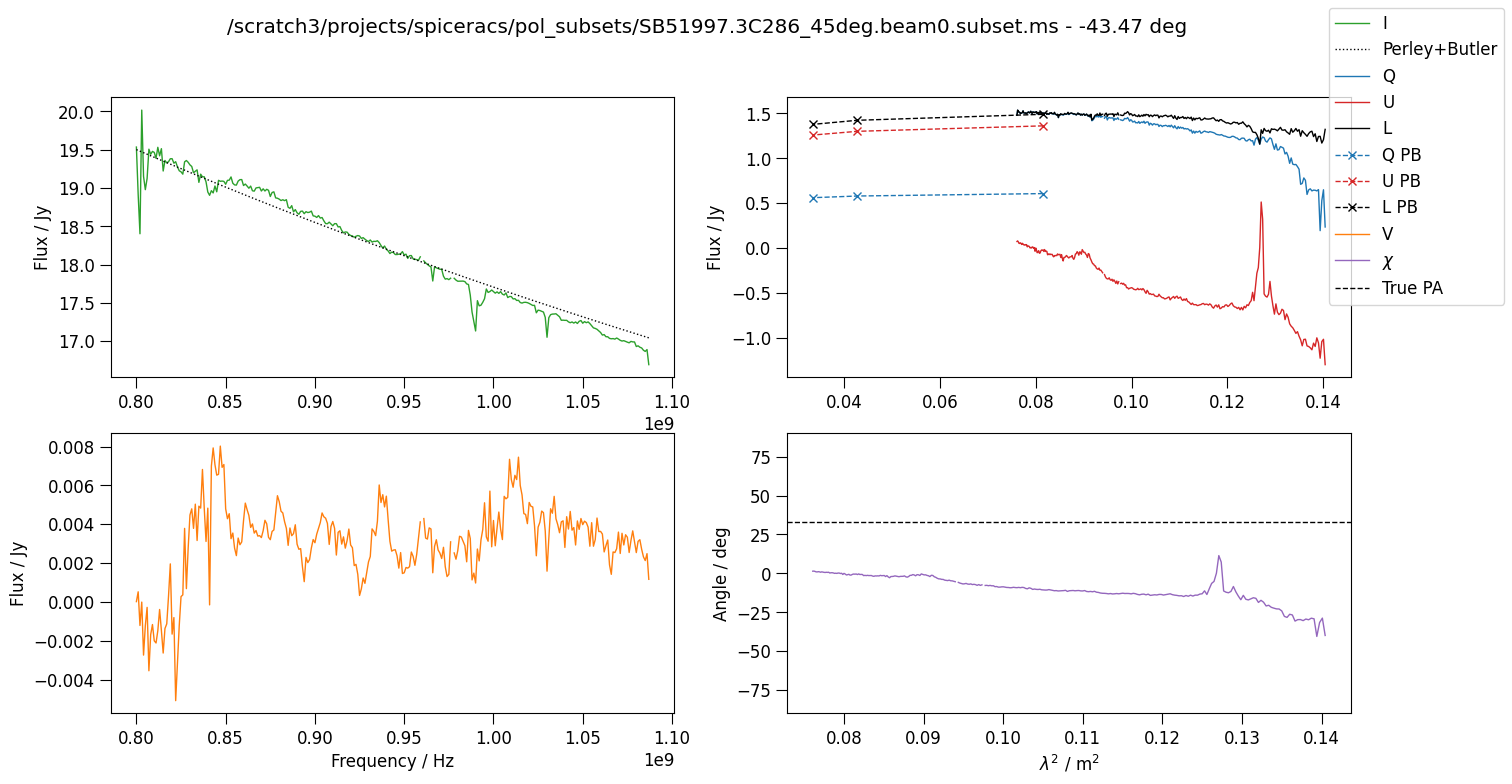

<Figure size 640x480 with 0 Axes>

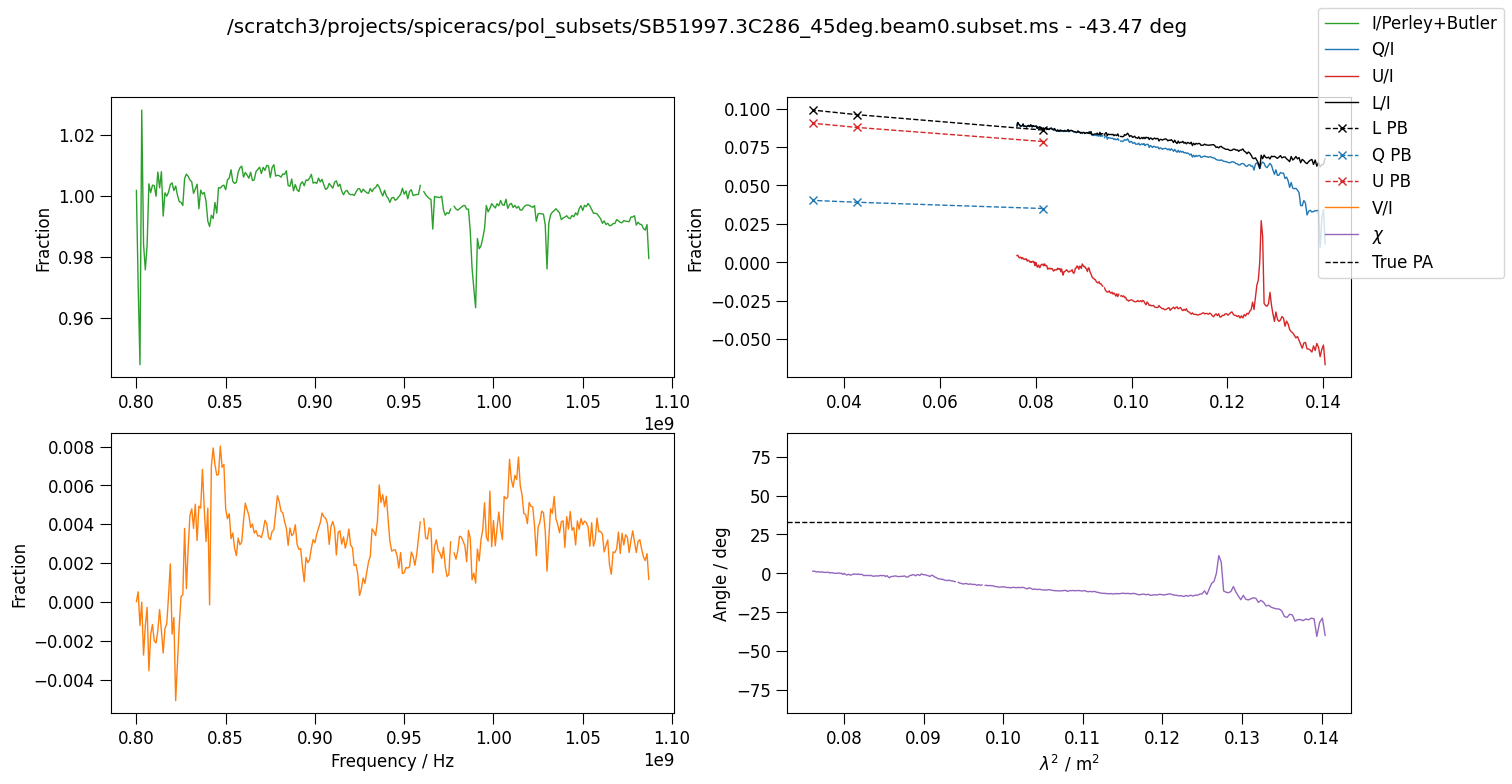

<Figure size 640x480 with 0 Axes>

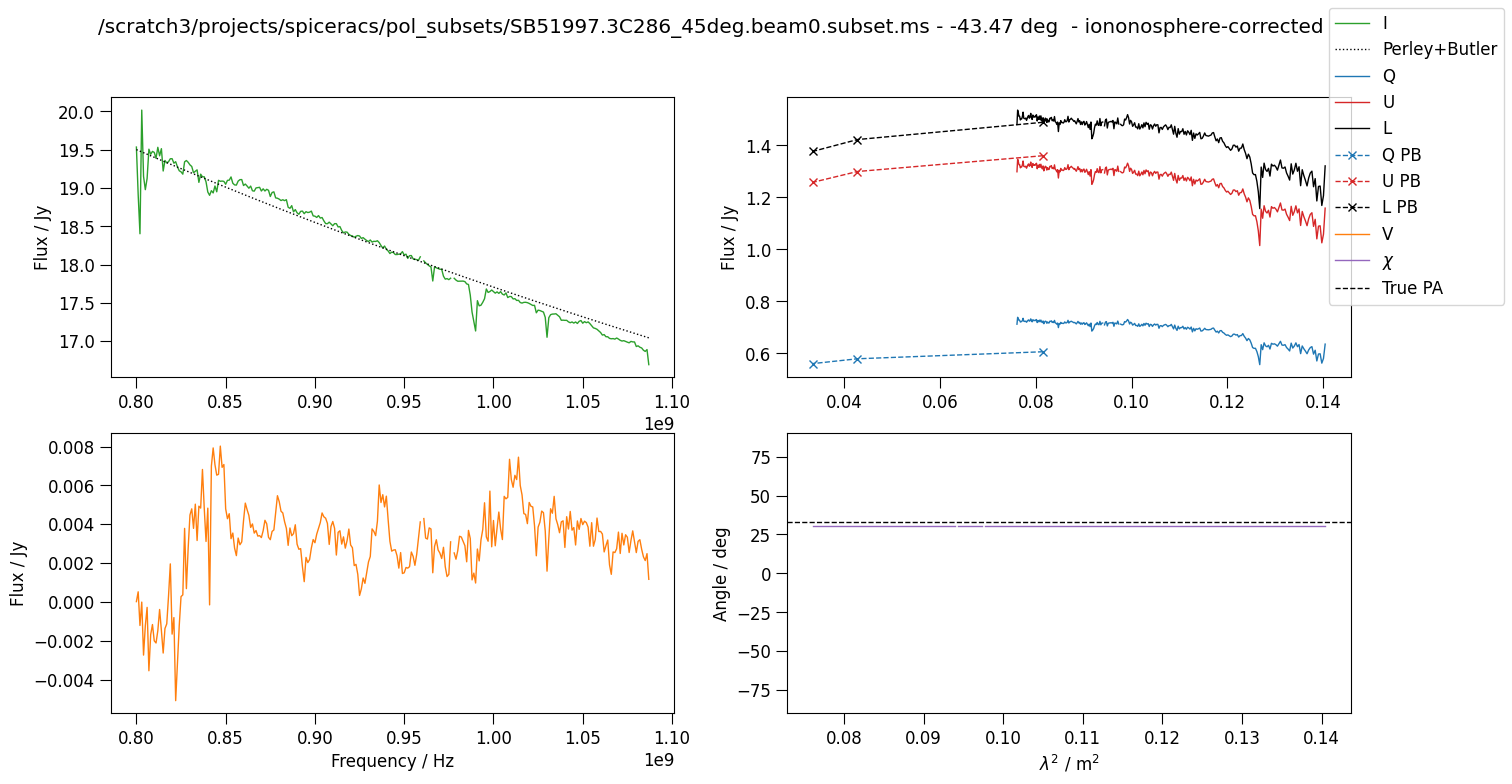

<Figure size 640x480 with 0 Axes>

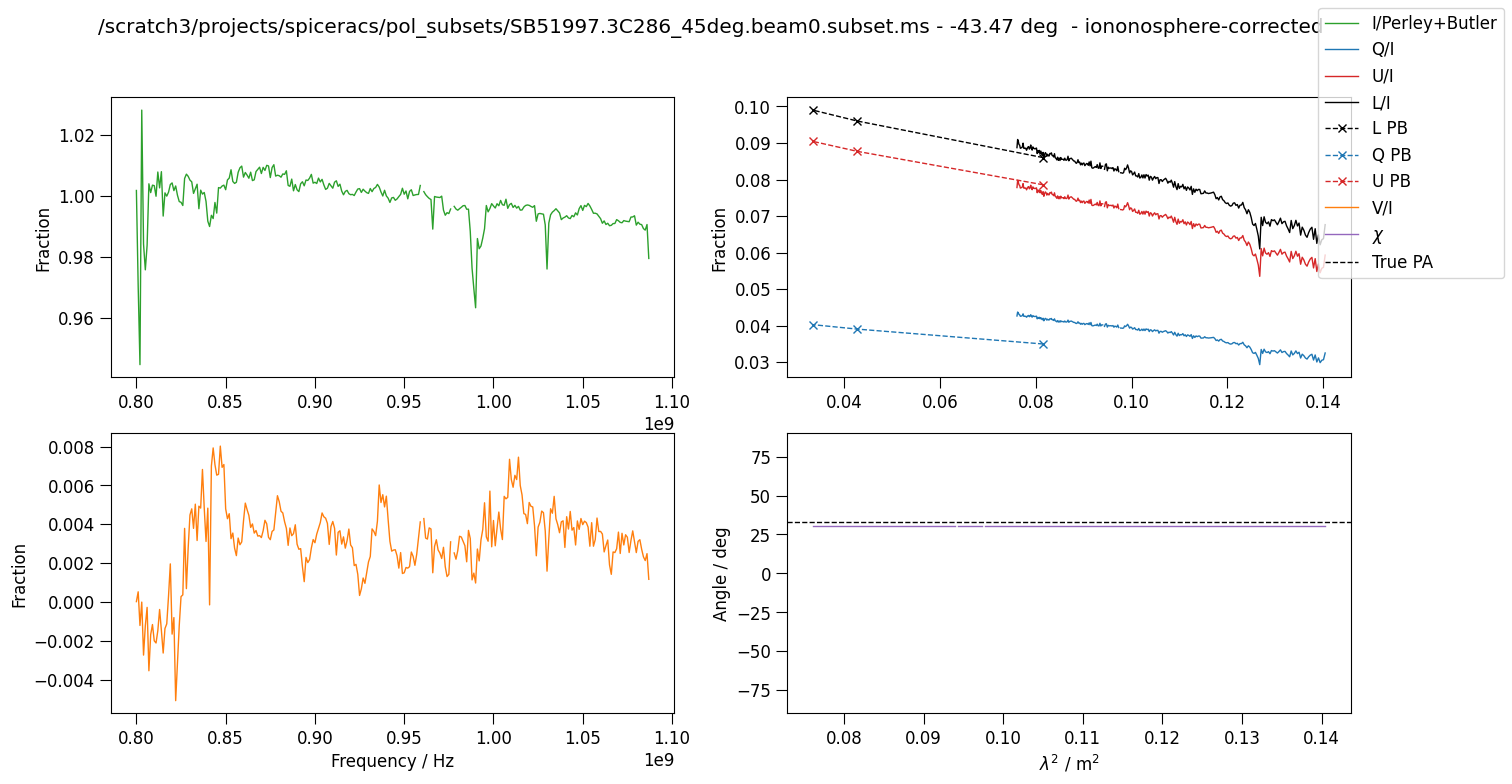

(<Figure size 1600x800 with 4 Axes>,
 {'I': <Axes: label='I', ylabel='Fraction'>,
  'P': <Axes: label='P', ylabel='Fraction'>,
  'V': <Axes: label='V', xlabel='Frequency / Hz', ylabel='Fraction'>,
  'A': <Axes: label='A', xlabel='$\\lambda^2$ / m$^2$', ylabel='Angle / deg'>})

<Figure size 640x480 with 0 Axes>

In [9]:
corrs_45  = get_corrs("/scratch3/projects/spiceracs/pol_subsets/SB51997.3C286_45deg.beam0.subset.ms", datacolumn="CORRECTED_DATA")
stokes_45 = corrs_to_stokes(corrs_45)
plot_stokes(stokes_45, title_extra="")
plot_fraction(stokes_45, title_extra="")
mDict_45, aDict_45 = run_rmsynth(
    [
        stokes_45.freq,
        stokes_45.i,
        stokes_45.q,
        stokes_45.u,
        np.ones_like(stokes_45.i) * 1e-3,
        np.ones_like(stokes_45.i) * 1e-3,
        np.ones_like(stokes_45.i) * 1e-3,
    ],
    showPlots=False,
    phiMax_radm2=100
)
ion_stokes_45 = fix_ion(stokes_45, mDict_45["polAngle0Fit_deg"] * np.pi / 180)

plot_stokes(ion_stokes_45, title_extra=" - iononosphere-corrected")
plot_fraction(ion_stokes_45, title_extra=" - iononosphere-corrected")

Successful readonly open of default-locked table /scratch3/projects/spiceracs/pol_subsets/SB52087.3C286_15deg.beam0.subset.ms/FEED: 12 columns, 1296 rows
Receptor angle for /scratch3/projects/spiceracs/pol_subsets/SB52087.3C286_15deg.beam0.subset.ms is [1.01478135 2.58557768] rad or [ 58.14268875 148.14268875] deg
Successful readonly open of default-locked table /scratch3/projects/spiceracs/pol_subsets/SB52087.3C286_15deg.beam0.subset.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful readonly open of default-locked table /scratch3/projects/spiceracs/pol_subsets/SB52087.3C286_15deg.beam0.subset.ms: 23 columns, 19980 rows


/tmp/ipykernel_42668/2482767806.py:33: RuntimeWarning: Mean of empty slice
  i = np.nanmean(i, axis=0)#.real
/tmp/ipykernel_42668/2482767806.py:34: RuntimeWarning: Mean of empty slice
  q = np.nanmean(q, axis=0)#.real
/tmp/ipykernel_42668/2482767806.py:35: RuntimeWarning: Mean of empty slice
  u = np.nanmean(u, axis=0)#.real


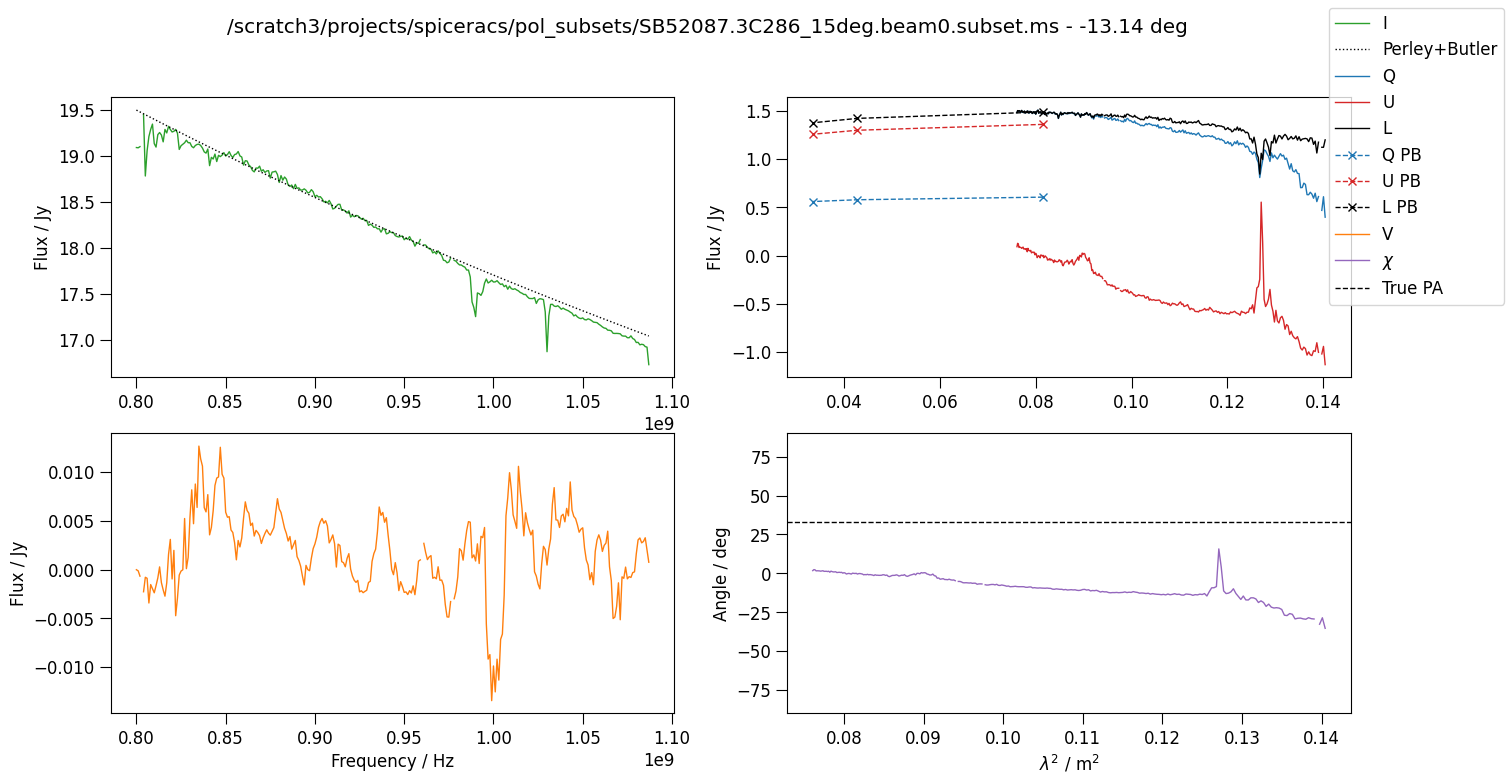

<Figure size 640x480 with 0 Axes>

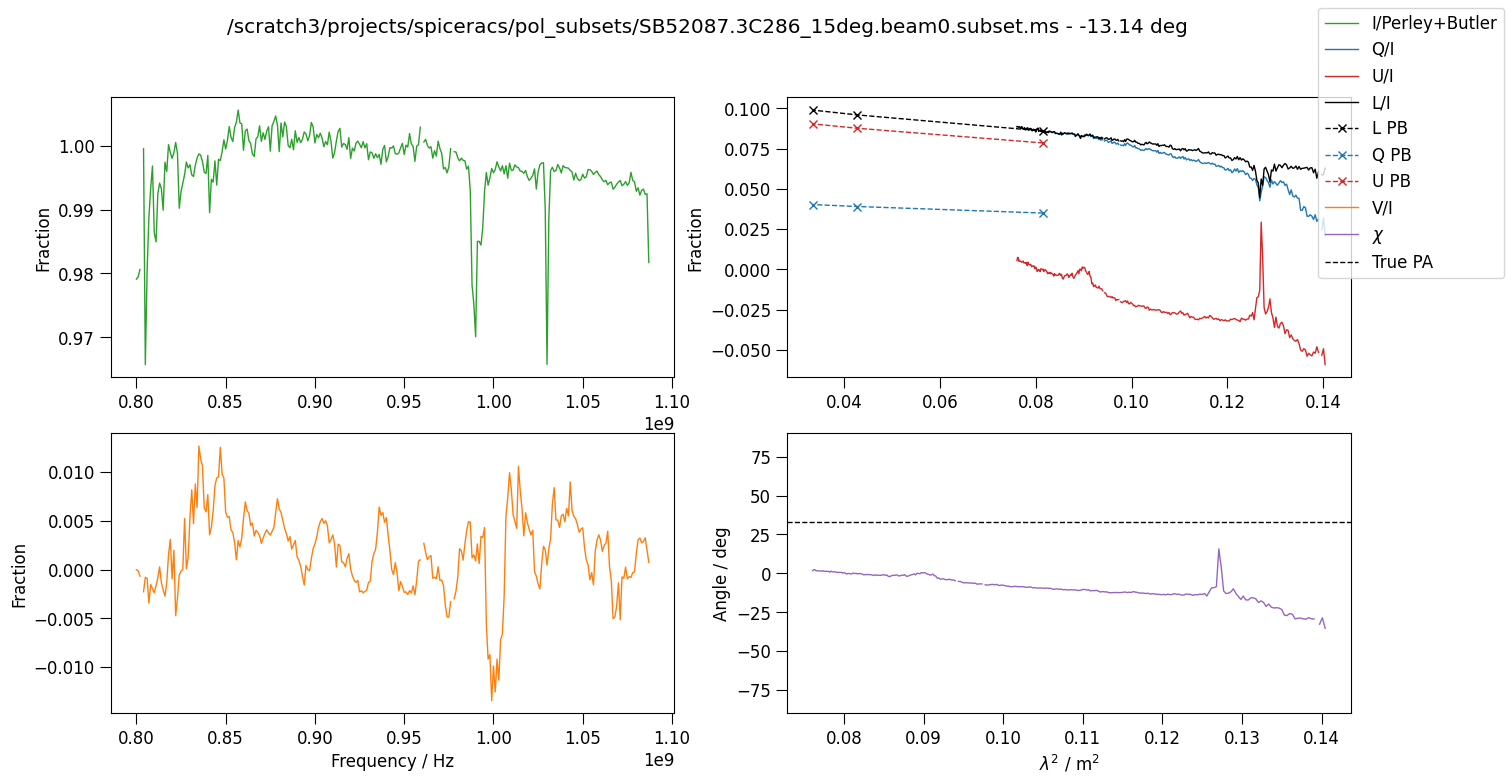

<Figure size 640x480 with 0 Axes>

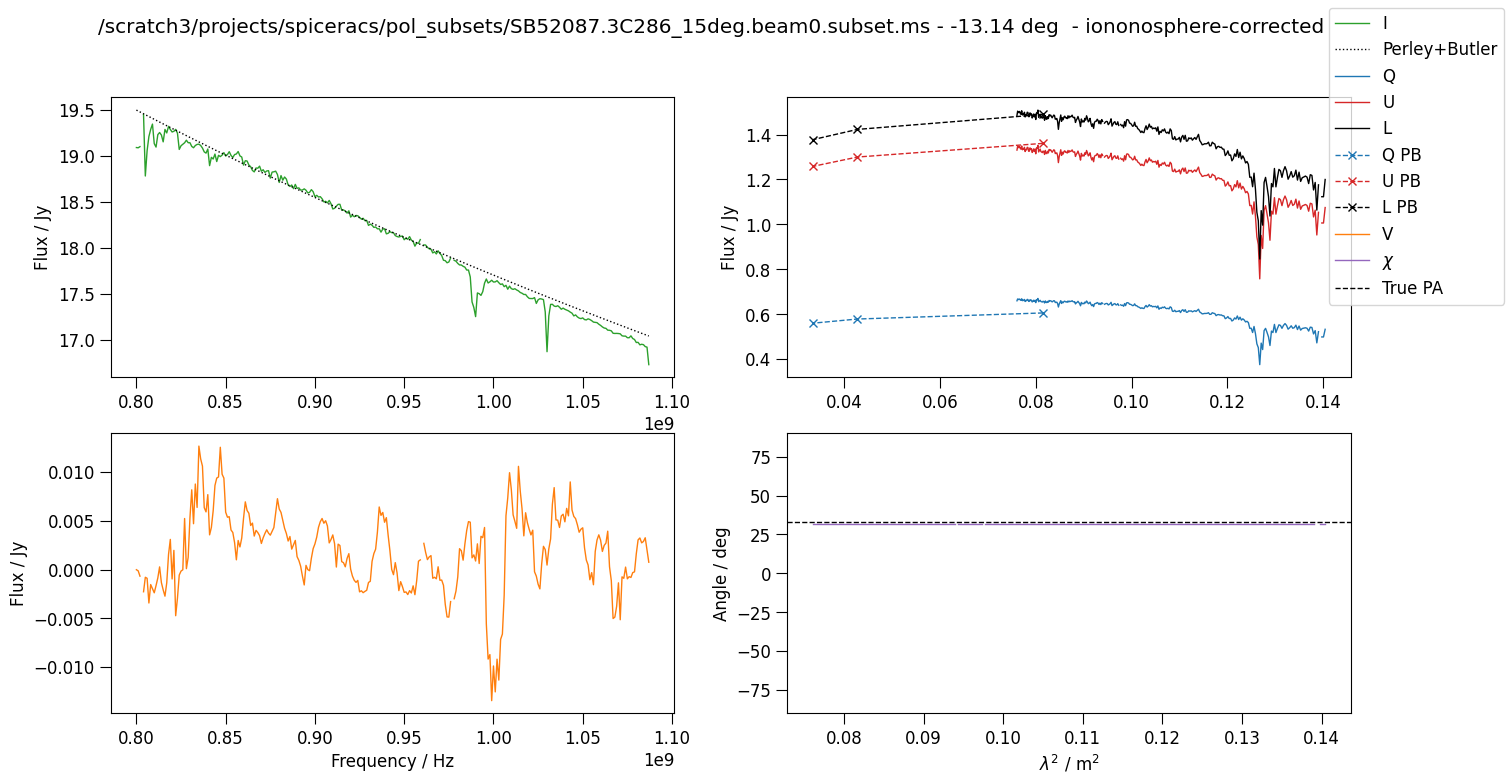

<Figure size 640x480 with 0 Axes>

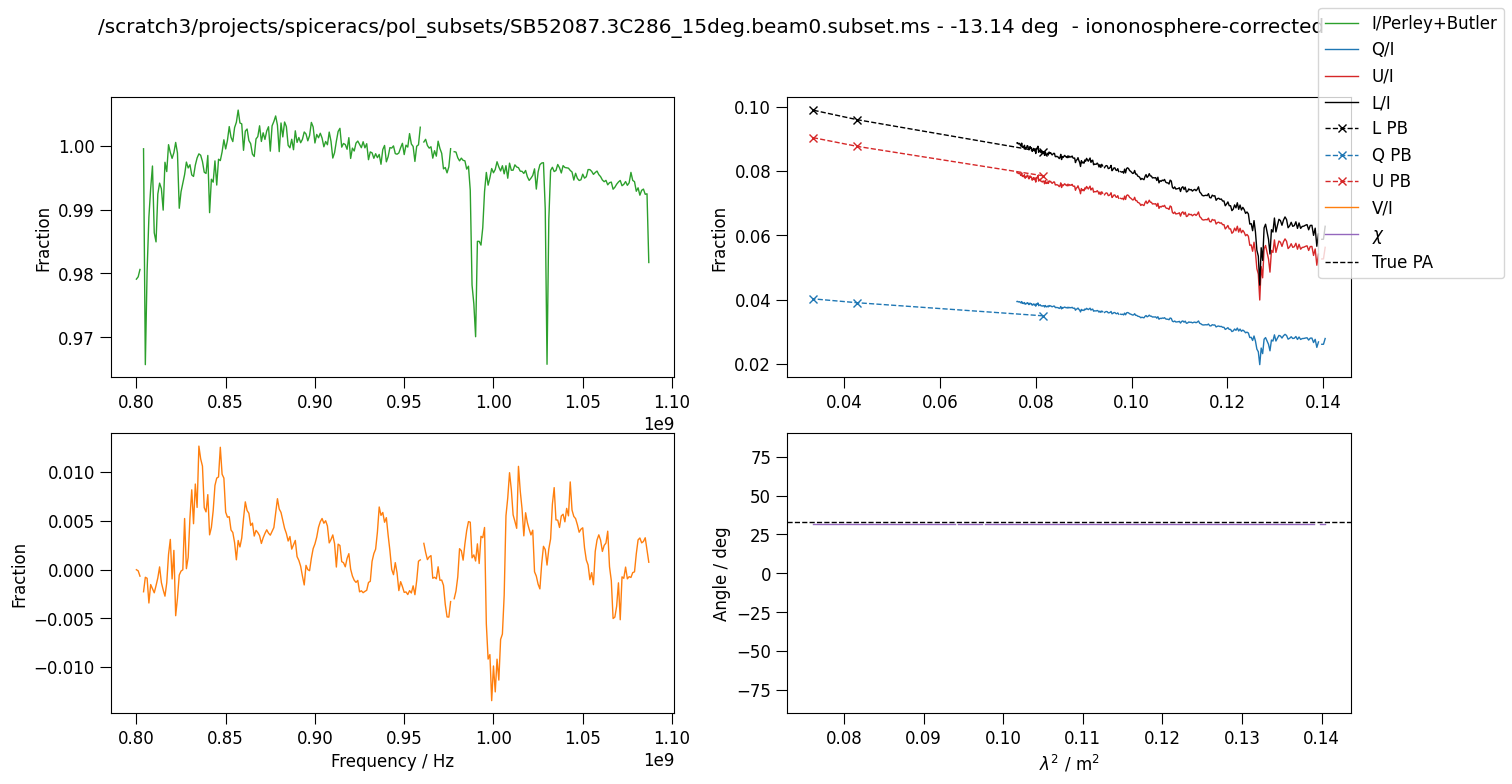

(<Figure size 1600x800 with 4 Axes>,
 {'I': <Axes: label='I', ylabel='Fraction'>,
  'P': <Axes: label='P', ylabel='Fraction'>,
  'V': <Axes: label='V', xlabel='Frequency / Hz', ylabel='Fraction'>,
  'A': <Axes: label='A', xlabel='$\\lambda^2$ / m$^2$', ylabel='Angle / deg'>})

<Figure size 640x480 with 0 Axes>

In [10]:
corrs_15  = get_corrs("/scratch3/projects/spiceracs/pol_subsets/SB52087.3C286_15deg.beam0.subset.ms", datacolumn="CORRECTED_DATA")
stokes_15 = corrs_to_stokes(corrs_15)
plot_stokes(stokes_15, title_extra="")
plot_fraction(stokes_15, title_extra="")
mDict_15, aDict_15 = run_rmsynth(
    [
        stokes_15.freq,
        stokes_15.i,
        stokes_15.q,
        stokes_15.u,
        np.ones_like(stokes_15.i) * 1e-3,
        np.ones_like(stokes_15.i) * 1e-3,
        np.ones_like(stokes_15.i) * 1e-3,
    ],
    showPlots=False,
    phiMax_radm2=100
)
ion_stokes_15 = fix_ion(stokes_15, mDict_15["polAngle0Fit_deg"] * np.pi / 180)

plot_stokes(ion_stokes_15, title_extra=" - iononosphere-corrected")
plot_fraction(ion_stokes_15, title_extra=" - iononosphere-corrected")

In [11]:
print(
    f"""
    Apparent ionospheric RM (assuming true RM = 0): 
        45deg offset: {mDict_45["phiPeakPIfit_rm2"]:0.1f} rad/m^2
        15deg offset: {mDict_15["phiPeakPIfit_rm2"]:0.1f} rad/m^2

    Apparent polarisation angle (true PA is 33 deg):
        45deg offset: {mDict_45["polAngle0Fit_deg"]:0.1f} deg
        15deg offset: {mDict_15["polAngle0Fit_deg"]:0.1f} deg

    Apparent offset in angles between 45deg and 15deg:
        {mDict_45["polAngle0Fit_deg"] - mDict_15["polAngle0Fit_deg"]:0.1f} deg (expected 30 deg)

    Apparent offset from true PA (33 deg):
        45deg offset: {mDict_45["polAngle0Fit_deg"] - TRUE_3C286_PA:0.1f} deg
        15deg offset: {mDict_15["polAngle0Fit_deg"] - TRUE_3C286_PA:0.1f} deg
    """
)


    Apparent ionospheric RM (assuming true RM = 0): 
        45deg offset: -6.6 rad/m^2
        15deg offset: -6.7 rad/m^2

    Apparent polarisation angle (true PA is 33 deg):
        45deg offset: 30.6 deg
        15deg offset: 31.8 deg

    Apparent offset in angles between 45deg and 15deg:
        -1.2 deg (expected 30 deg)

    Apparent offset from true PA (33 deg):
        45deg offset: -2.4 deg
        15deg offset: -1.2 deg
    


In [12]:
from spectral_cube import SpectralCube

In [19]:
beam = 0
# SB51997.3C286_45deg.linmos.q.cube.pbcor.fits
icube = SpectralCube.read(f"/scratch3/projects/spiceracs/askap_pol_testing/cubes/SB51997.3C286_45deg.beam{beam}.icube.fits")
qcube = SpectralCube.read(f"/scratch3/projects/spiceracs/askap_pol_testing/cubes/SB51997.3C286_45deg.beam{beam}.qcube.fits")
ucube = SpectralCube.read(f"/scratch3/projects/spiceracs/askap_pol_testing/cubes/SB51997.3C286_45deg.beam{beam}.ucube.fits")

icube_pb = SpectralCube.read(
    f"/scratch3/projects/spiceracs/askap_pol_testing/cubes/cutouts/3C286/3C286.cutout.i.SB51997.3C286_45deg.linmos.fits"
)
qcube_pb = SpectralCube.read(
    f"/scratch3/projects/spiceracs/askap_pol_testing/cubes/cutouts/3C286/3C286.cutout.q.SB51997.3C286_45deg.linmos.fits"
)
ucube_pb = SpectralCube.read(
    f"/scratch3/projects/spiceracs/askap_pol_testing/cubes/cutouts/3C286/3C286.cutout.u.SB51997.3C286_45deg.linmos.fits"
)

In [20]:
three_c286 = SkyCoord.from_name("3C286")
x, y = icube.wcs.celestial.world_to_pixel(three_c286)

box = int(icube.pixels_per_beam//2)
ispec = icube[:,int(y)//2-box:int(y)+box, int(x)-box:int(x)+box].sum(axis=(1,2)) / icube.pixels_per_beam
qspec = qcube[:,int(y)-box:int(y)+box, int(x)-box:int(x)+box].sum(axis=(1,2)) / icube.pixels_per_beam
uspec = ucube[:,int(y)-box:int(y)+box, int(x)-box:int(x)+box].sum(axis=(1,2)) / icube.pixels_per_beam

x, y = icube_pb.wcs.celestial.world_to_pixel(three_c286)
ispec_pb = icube_pb[:,int(y)-box:int(y)+box, int(x)-box:int(x)+box].sum(axis=(1,2)) / icube_pb.pixels_per_beam
qspec_pb = qcube_pb[:,int(y)-box:int(y)+box, int(x)-box:int(x)+box].sum(axis=(1,2)) / icube_pb.pixels_per_beam
uspec_pb = ucube_pb[:,int(y)-box:int(y)+box, int(x)-box:int(x)+box].sum(axis=(1,2)) / icube_pb.pixels_per_beam

pspec = np.hypot(qspec, uspec)
aspec = 0.5 * np.arctan2(uspec, qspec)

pspec_pb = np.hypot(qspec_pb, uspec_pb)
aspec_pb = 0.5 * np.arctan2(uspec_pb, qspec_pb)

(0.0, 25.0)

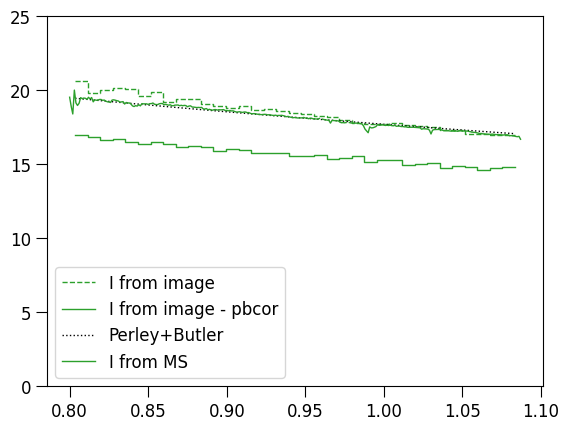

In [24]:
nu_g = ispec.spectral_axis.to("GHz").value
nu_g_log = np.log10(nu_g)
pb_model_log = PB_scales[0] + \
            PB_scales[1] * nu_g_log + \
            PB_scales[2] * nu_g_log**2 + \
            PB_scales[3] * nu_g_log**3
pb_model = 10**(pb_model_log)

plt.step(
    nu_g,
    ispec,
    label="I from image",
    color="tab:green",
    linestyle="--",
)
plt.step(
    nu_g,
    ispec_pb,
    label="I from image - pbcor",
    color="tab:green",
    linestyle="-",
)
plt.plot(
    nu_g,
    pb_model,
    label="Perley+Butler",
    color="k",
    linestyle=":",
)
plt.plot(
    stokes_45.freq / 1e9,
    stokes_45.i,
    label="I from MS",
    color="tab:green",
)
plt.legend()
plt.ylim(0, 25)

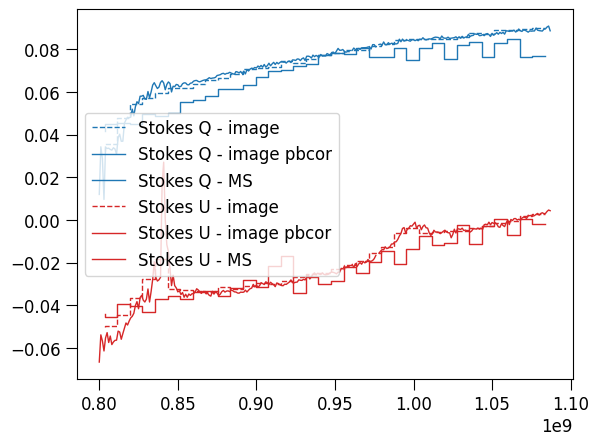

In [22]:
fig, ax = plt.subplots()
lsq = (2.998e8 / pspec.spectral_axis.to("Hz").value)**2
ax.step(ispec.spectral_axis.to("Hz"), qspec / ispec, color="tab:blue", label="Stokes Q - image", linestyle="--")
ax.step(ispec_pb.spectral_axis.to("Hz"), qspec_pb / ispec_pb, color="tab:blue", label="Stokes Q - image pbcor")
ax.plot(stokes_45.freq, stokes_45.q / stokes_45.i, color="tab:blue", label="Stokes Q - MS")

ax.step(ispec.spectral_axis.to("Hz"), uspec / ispec, color="tab:red", label="Stokes U - image", linestyle="--")
ax.step(ispec_pb.spectral_axis.to("Hz"), uspec_pb / ispec_pb, color="tab:red", label="Stokes U - image pbcor")
ax.plot(stokes_45.freq, stokes_45.u / stokes_45.i, color="tab:red", label="Stokes U - MS")
ax.legend()

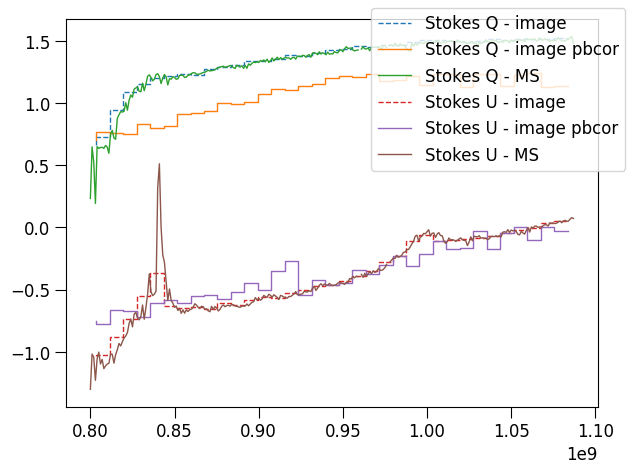

In [23]:
fig, ax = plt.subplots()
lsq = (2.998e8 / pspec.spectral_axis.to("Hz").value)**2
ax.step(ispec.spectral_axis.to("Hz"), qspec, label="Stokes Q - image", linestyle="--")
ax.step(ispec_pb.spectral_axis.to("Hz"), qspec_pb, label="Stokes Q - image pbcor")
ax.plot(stokes_45.freq, stokes_45.q, label="Stokes Q - MS")

ax.step(ispec.spectral_axis.to("Hz"), uspec, label="Stokes U - image", linestyle="--")
ax.step(ispec_pb.spectral_axis.to("Hz"), uspec_pb, label="Stokes U - image pbcor")
ax.plot(stokes_45.freq, stokes_45.u, label="Stokes U - MS")
fig.legend()
fig.tight_layout()

In [18]:
# fig, ax = plt.subplots()
# lsq = (2.998e8 / pspec.spectral_axis.to("Hz").value)**2
# ax.step(ispec.spectral_axis.to("Hz"), qspec / ispec /2, color="tab:blue", label="Stokes Q - image /2")
# ax.plot(ion_stokes_45.freq, ion_stokes_45.q / ion_stokes_45.i, color="tab:blue", label="Stokes Q - MS")
# ax.step(ispec.spectral_axis.to("Hz"), uspec / ispec, color="tab:red", label="Stokes U - image")
# ax.plot(ion_stokes_45.freq, ion_stokes_45.u / ion_stokes_45.i, color="tab:red", label="Stokes U - MS")
# ax.legend()